# Further debug


### Directory Fix

In [113]:
# project directory fix
import os
import sys
sys.path.append('./src')
os.chdir(os.path.dirname(os.path.dirname(sys.path[0])))

### Combined Imports/Params/Util

In [114]:
from mesa_geo import GeoAgent, GeoSpace
from mesa.time import BaseScheduler, RandomActivation, SimultaneousActivation
from mesa import datacollection
from mesa import Model
from scipy import stats 
from inspect import signature
import math
import os
import sys
import warnings


#Shapely Imports
from shapely.geometry import Polygon, Point, LineString
import shapely


#Data Analysis 
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import csv

# Configuration Data and Files
import configparser

#Plot
import matplotlib.pyplot as plt

# Aerosol Transmission
import aerosol_new
import transmission_rate as trans_rate

# Prefix for config data
#os.chdir(os.path.dirname(sys.path[0]))
config_file_path_prefix = './config/'


# parser viz config data
viz_ini_file = 'vizparams.ini'

parser_viz = configparser.ConfigParser()
parser_viz.read(config_file_path_prefix + viz_ini_file)

default_section = parser_viz['DEFAULT_PARAMS']


# parser disease config data

disease_params_ini = 'diseaseparams.ini'
parser_dis = configparser.ConfigParser()
parser_dis.read(config_file_path_prefix + disease_params_ini)
incubation = parser_dis['INCUBATION']


# NPI config data


npi_params_ini = 'NPI.ini'
parser_npi = configparser.ConfigParser()
parser_npi.read(config_file_path_prefix + npi_params_ini)


# school config data


school_params_ini = 'schoolparams.ini'
parser_school = configparser.ConfigParser()
parser_school.read(config_file_path_prefix + school_params_ini)
population_config = parser_school['SCHOOL_POPULATION']
cohort_config = parser_school['COHORT']




def generate_random(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            return pnt
        
        
        
        
        
        
def find_room_type(room_agents, room_type):
    """
    room_agents: a list containing room agents
    room_type: a valid string of room type: [None, 'restroom_grade_boys', 'lunch_room', 'classroom_grade',
       'restroom_all', 'restroom_grade_girls', 'restroom_KG',
       'classroom_KG', 'community_room', 'library',
       'restroom_special_education', 'restroom_faculty',
       'classroom_special_education', 'health_room', 'faculty_lounge',
       'classroom_preschool', 'restroom_preschool']
    """
    out = []
    for agent in room_agents:
        if agent.room_type == room_type:
            out.append(agent)
    return out








        
        



            


## Human Agents

In [115]:
countdown = parser_dis['COUNTDOWN']
shape, loc, scale =  (float(countdown['shape']), float(countdown['loc']), float(countdown['scale']))

lognormal_dist = stats.lognorm.rvs(shape, loc, scale, size=1000)

(array([ 28.,  80., 109.,  94., 101.,  83.,  91.,  56.,  57.,  41.,  42.,
         44.,  26.,  16.,  21.,  18.,  13.,   9.,   9.,   4.,  10.,   9.,
          9.,   4.,   3.,   0.,   3.,   4.,   7.,   1.,   0.,   1.,   2.,
          0.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.61294899,  1.21720114,  1.8214533 ,  2.42570545,  3.02995761,
         3.63420976,  4.23846192,  4.84271407,  5.44696623,  6.05121838,
         6.65547054,  7.25972269,  7.86397485,  8.468227  ,  9.07247916,
         9.67673131, 10.28098347, 10.88523563, 11.48948778, 12.09373994,
        12.69799209, 13.30224425, 13.9064964 , 14.51074856, 15.11500071,
        15.71925287, 16.32350502, 16.92775718, 17.53200933, 18.13626149,
        18.74051364, 19.3447658 , 19.94901795, 20.55327011, 21.15752226,
        21.76177442, 22.36602657, 22.97027873, 23.57453088, 24.17878304,
        24.78303519, 25.38728735, 25.9915395 , 26.59579166, 27.20004381,
 

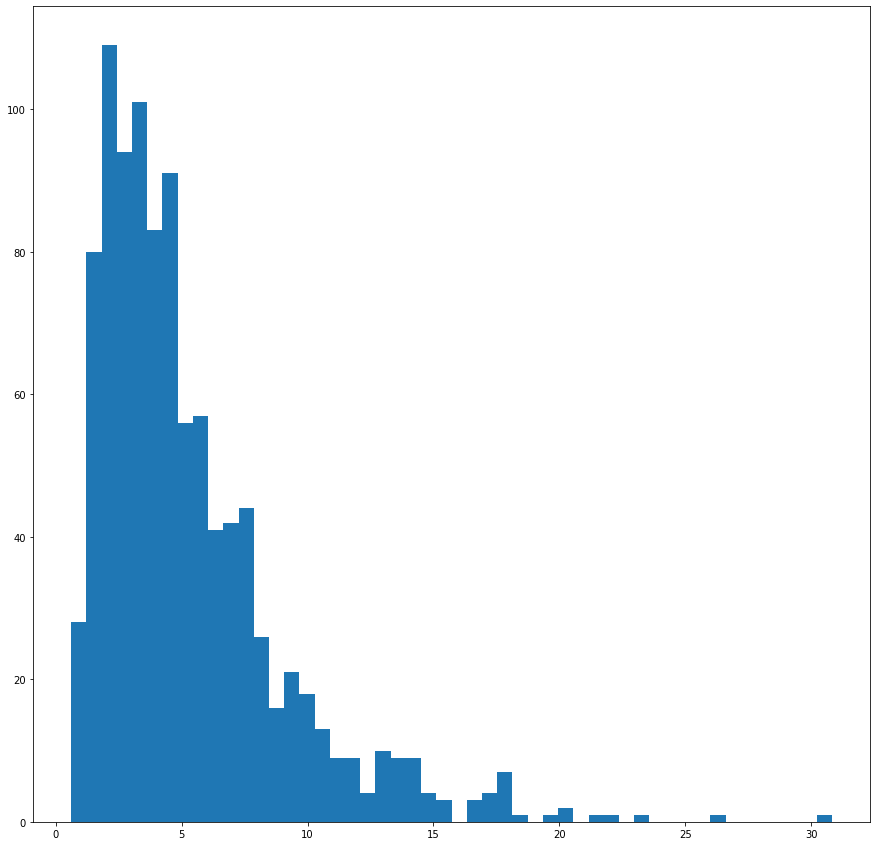

In [116]:
plt.hist(sorted(lognormal_dist), bins=50)

In [117]:
infective_df

,x,gamma
0,-10,3.584841e-09
1,-9,1.170157e-06
2,-8,4.868625e-05
3,-7,6.372789e-04
4,-6,3.973076e-03
5,-5,1.477747e-02
6,-4,3.756865e-02
7,-3,7.132390e-02
8,-2,1.074581e-01
9,-1,1.342055e-01


In [118]:
import transmission_rate as trans_rate


# infectious curve config
###################################### 
# based on gamma fit of 10000 R code points

shape, loc, scale = (float(incubation['shape']), float(incubation['loc']), float(incubation['scale']))

# infectious curve
range_data = list(range(int(incubation['lower_bound']), int(incubation['upper_bound']) + 1))
infective_df = pd.DataFrame(
    {'x': range_data,
     'gamma': list(stats.gamma.pdf(range_data, a=shape, loc=loc, scale=scale))
    }
)
#########################################



class Human(GeoAgent):
            
    # plot config

    marker = default_section['marker']
    colordict = {"healthy": default_section['healthy'], 'exposed': default_section['exposed'], 'infectious': default_section['infectious']}
    edgedict = {"healthy": default_section['healthy_edge'], 'exposed': default_section['exposed_edge'], 'infectious': default_section['infectious_edge']}
    sizedict = {"healthy": default_section['healthy_size'], 'exposed': default_section['exposed_size'], 'infectious': default_section['infectious_size']}
    
    
    
    
    # dummy config for data collection
    viral_load = None
    
    
    
    # UPDATE 10/16: move stats to class level
     

    
    
    
    


    
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy'):
        super().__init__(unique_id, model, shape)
        
        # mask setup
        # defualt to no mask
        self.mask_type = None
        self.mask_passage_prob = trans_rate.return_mask_passage_prob(self.mask_type)
        
        # disease config

        self.health_status = health_status
        prevalence = float(parser_dis['ASYMPTOMATIC_PREVALENCE']['prevalence'])
        self.asymptomatic = np.random.choice([True, False], p = [prevalence, 1-prevalence])
        self.symptoms = False


        # TODO: vaccination should be parameterized (effective rate, etc.)
        self.tested = False
        self.vaccinated = False
        
        self.infective = False
        
        # symptom onset countdown config
        ##########################################
        # From 10000 lognorm values in R
        countdown = parser_dis['COUNTDOWN']
        shape, loc, scale =  (float(countdown['shape']), float(countdown['loc']), float(countdown['scale']))

        lognormal_dist = stats.lognorm.rvs(shape, loc, scale, size=1)

        
        num_days = max(int(countdown['lower_bound']), 
                       min(np.round(lognormal_dist, 0)[0], 
                           int(countdown['upper_bound'])))# failsafe to avoid index overflow
        self.symptom_countdown = int(num_days)
        #######################################
        
        

        
        self.room = room
        self.x = self.shape.x
        self.y = self.shape.y
        
        


        
        

 
    def update_shape(self, new_shape):
        self.shape = new_shape
        self.x = self.shape.x
        self.y = self.shape.y
        
    
    def __update(self):
        # UPDATE 10/16: reorganized things from Bailey's update
        # TODO: currently mask has no functionality other than reducing transmission distance, is this faithful?

        # mask wearing reduces droplet transmission max range
        # infection above max range is considered as aerosal transmission

        
        #if self.mask and not (self.model.activity[self.room.schedule_id] == 'lunch'):
        
        # chu distance multiplier would be < 0.001 above 30 feet for infection
        max_infect_dist = 30
        neighbors = self.model.grid.get_neighbors_within_distance(self, max_infect_dist)
        
        #else:
        #    neighbors = self.model.grid.get_neighbors_within_distance(self, int(parser_npi['NO_NPI']['infection_distance']))

        

                        
                        
                        
        if self.health_status == 'exposed' and self.infective:



            for neighbor in neighbors:

                # Check class is Human and are within the same room                           
                if issubclass(type(neighbor), Human) and self.__check_same_room(neighbor) :
                    if neighbor.unique_id != self.unique_id and (neighbor.health_status == 'healthy'):                   
                        # Call Droplet transmission function
                        temp_prob = self.droplet_infect(self, neighbor)
                        infective_prob = np.random.choice ([True, False], p = [temp_prob, 1-temp_prob])
                        if infective_prob and not neighbor.vaccinated:
                            neighbor.health_status = 'exposed'

    
    @staticmethod
    def droplet_infect(infected, uninfected):
        '''
        baseline transmission rate
        '''
        feet_to_meter = 1/3.2808
        distance = infected.shape.distance(uninfected.shape)*feet_to_meter
        
        # normalize symptom countdown value to infectious distribution value
        # 0 being most infectious
        # either -10 or 8 is proven to be too small of a chance to infect others, thus covering asympotmatic case
        
        countdown_norm = min(int(incubation['upper_bound']), max(int(incubation['lower_bound']), 0 - infected.symptom_countdown))
        transmission_baseline = infective_df[infective_df['x'] == countdown_norm]['gamma'].iloc[0]

     
        # Use Chu distance calculation ## see docs
        chu_distance_multiplier = 1/2.02
        distance_multiplier = (chu_distance_multiplier)**distance                                                        

        
        # approximate student time spent breathing vs talking vs loudly talking
        # TODO Kaushik/Bailey: adjust to aerosal version
        breathing_type_multiplier = np.random.choice([.1, .5, 1], p=[.2, .05, .75])
        # whisper, loud, heavy

        # Mask Passage: 1 = no masks, .1 = cloth, .05 = N95
        mask_multiplier = np.mean([infected.mask_passage_prob, uninfected.mask_passage_prob])

        # Lunch special case: mask off during lunch time
        if infected.model.activity[infected.room.schedule_id] == 'lunch':
            mask_multiplier = 1
        # convert transmission rate / hour into transmission rate / step
        hour_to_fivemin_step = 5/60

        return transmission_baseline * distance_multiplier * breathing_type_multiplier * mask_multiplier * hour_to_fivemin_step


                        
    def __check_same_room(self, other_agent):
        '''
        check if current agent and other agent is in the same room
        
        the purpose of this function is to make sure to eliminate edge cases that one agent near the wall of its room
        infects another agent in the neighboring room
        
        this is at this iteration of code only implemented for class purpose, as unique id check is way more efficient
        
        later implementation should add attribute to human agent for current room
        
            other_agent: other agent to check
            returns: boolean value for if the two agents are in the same room
        '''
        same_room = True
        if self.model.activity[self.room.schedule_id] == 'class':
            same_room = (self.room.unique_id == other_agent.room.unique_id)
        return same_room
    
    
    def __move(self, move_spread = 4, location = None):
        '''
        Checks the current location and the surrounding environment to generate a feasbile range of destination (the area
        of a circle) for agent to move to.
        The radius of the circle is determined by agent's move_factor.
        Assigns new point to override current point.
        '''   
        
        if not location:
            location = self.room
        move_spread = location.shape.intersection(self.shape.buffer(move_spread))
        if hasattr(location, 'seating_pattern'):
            if location.seating_pattern == 'circular':
                move_spread = shapely.ops.cascaded_union(list(location.desks.values())).difference(move_spread)
        try:
            minx, miny, maxx, maxy = move_spread.bounds 
                
            while True:
                pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))            
                # check if point lies in true area of polygon
                if move_spread.contains(pnt):
                    self.update_shape(pnt)
                    break
        except:
            pass


    
    
    def plot(self):
        plt.plot(
            self.shape.x, self.shape.y, 
            marker=self.marker, 
            mec = self.edgedict[self.health_status],
            color = self.colordict[self.health_status],
            markersize = self.sizedict[self.health_status]
                )
        

                        
        
        
        





class Student(Human):
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy', mask_on=False):
        super().__init__(unique_id, model, shape, room, health_status)

        viz_ini_file = 'vizparams.ini'
        parser = configparser.ConfigParser()
        parser.read(config_file_path_prefix + viz_ini_file)
        student_viz_params = parser['STUDENT']

        self.grade = self.room.room_type.replace('classroom_', '')
        
        
        # mask setup
        self.mask = mask_on      
        mask_probs = [eval(parser_npi['MASK_PROB']['cotton']), 
                      eval(parser_npi['MASK_PROB']['multilayer']),
                      eval(parser_npi['MASK_PROB']['surgical']),
                      eval(parser_npi['MASK_PROB']['n95'])]
        if mask_on:
            self.mask_type = np.random.choice(['Cotton', 'Multilayer', 'Surgical', 'N95'], p = mask_probs)
        else:
            self.mask_type = None
        self.mask_passage_prob = trans_rate.return_mask_passage_prob(self.mask_type)
        
        
        self.seat = Point(self.shape.x, self.shape.y)
        self.marker = student_viz_params['marker']
        
        
        

        self.out_of_place = False        
        self.prev_activity = None
        self.lunch_count = 0
        self.desks = None
        self.breathing_rate = None
        self.breathing_activity = None
        
        
        
        
        
                

    def step(self):
        self._Human__update()
        
        
        if self.model.schedule_type != "Simultaneous":
            self.advance()                

                
                
    def advance(self):
        activity = self.model.activity[self.room.schedule_id]
        # case 1: student in class
        if activity == 'class': 
            if self.prev_activity != activity:
                self.prev_activity = activity
                self.update_shape(self.seat)
                self.breathing_rate = 'resting'
                
                #TODO: The probability should be in init file
                self.breathing_activity = np.random.choice(['talking_whisper', 'talking_loud', 'breathing_heavy'], p=[0.2, 0.05, 0.75])

                
            if self.room.prob_move:
                # TODO: this should change breathing activity prob slightly
                self.out_of_place = True
                self._Human__move()
            else:
                if self.out_of_place:
                    self.update_shape(self.seat)
                    self.out_of_place = False
                    
                
                
        # case 2: student in recess            
        elif activity == 'recess':
            
            self.breathing_rate = 'NA'
            
            
            if self.prev_activity != activity:
                self.update_shape(generate_random(self.cohort.shape))
                self.prev_activity = activity
            
            self._Human__move(move_spread=5, location = self.cohort)
        
        
        
        # case 3: student having lunch
        elif activity == 'lunch':
            self.breathing_rate = 'resting'
            self.breathing_activity = 'breathing_heavy'
            #in class lunch case
            if self.model.inclass_lunch or self.grade != 'grade':
                if self.prev_activity != activity:
                    self.update_shape(self.seat)
                    self.prev_activity = activity
                    self.out_of_place = True
                    self._Human__move()
                else: 
                    if self.out_of_place:
                        self.update_shape(self.seat)
                        self.out_of_place = False

                    
            #in cafeteria lunch case
            else:
                if self.prev_activity != activity:
                    self.update_shape(generate_random(self.model.lunchroom.shape))
                    self.prev_activity = activity

                # enter lunch cafeteria, move free for 2 iteration
                if self.lunch_count < 2:
                    self._Human__move(move_spread=10, location = self.model.lunchroom)

                # finds seat, settle in seat until finish lunch
                elif self.lunch_count == 2:
                    self.update_shape(self.model.lunchroom.seats[0])
                    # remove seat from seat list if the student occupies it
                    self.model.lunchroom.seats = self.model.lunchroom.seats[1:]

                # release seat back to seat list
                elif self.lunch_count == 7:
                    self.model.lunchroom.seats.append(self.shape)
                    self.lunch_count = -1

            
                self.lunch_count += 1
    
                        
                            
                            
                            




                
                
    
class Teacher(Human):
    def __init__(self, unique_id, model, shape, room, health_status = 'healthy',mask_on=True):
        super().__init__(unique_id, model, shape, room, health_status)
        
        
        # mask setup
        self.mask = mask_on      
        mask_probs = [eval(parser_npi['MASK_PROB']['cotton']), 
                      eval(parser_npi['MASK_PROB']['multilayer']),
                      eval(parser_npi['MASK_PROB']['surgical']),
                      eval(parser_npi['MASK_PROB']['n95'])]
        if mask_on:
            self.mask_type = np.random.choice(['Cotton', 'Multilayer', 'Surgical', 'N95'], p = mask_probs)
        else:
            self.mask_type = None
        self.mask_passage_prob = trans_rate.return_mask_passage_prob(self.mask_type)
        
        
        
        self.classroom = self.room # TODO: for future development enabling Teachers to move to other room during non-class time
        self.breathing_rate = None
        self.breathing_activity = None

        viz_ini_file = 'vizparams.ini'
        parser = configparser.ConfigParser()
        parser.read(config_file_path_prefix + viz_ini_file)
        teacher_viz_params = parser['TEACHER']
        
        self.marker = teacher_viz_params['marker']
        self.edgedict = {"healthy": teacher_viz_params['healthy_edge'], 'exposed': teacher_viz_params['exposed_edge'], 'infectious': teacher_viz_params['infectious_edge']}
        self.sizedict = {"healthy": teacher_viz_params['healthy_size'], 'exposed': teacher_viz_params['exposed_size'], 'infectious': teacher_viz_params['infectious_size']}
    
    
    def step(self):
        self.breathing_rate = 'light_exercise'
        self.breathing_activity = np.random.choice(['talking_loud', 'talking_normal', 'breathing_heavy'], p=[0.5, 0.25, 0.25])
        self._Human__update()
        
                
        if self.model.schedule_type != "Simultaneous":
            self.advance()
            
    def advance(self):
        self._Human__move()
                
        

## Room Agents

In [119]:
school_intervention_params = parser_school['INTERVENTION']
    

class Classroom(GeoAgent):
    
    
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    
    
    def __init__(self, unique_id, model, shape, room_type):
        super().__init__(unique_id, model, shape)
        self.occupants = []
        self.aerosol_transmission_rate = []
        #self.occupants = occupants #List of all occupants in a classroom
        #self.barrier = barrier_type
        self.room_type = room_type
        self.seating_pattern = None
        self.viral_load = 0
        self.prob_move = False
        self.schedule_id = None
        
        
        # volume
        self.floor_area = shape.area
        self.height = 12

        # airflow ventiliation type
        self.environment = eval(school_intervention_params['ventilation_type'])
    
    def step(self):
        # roll weighted probability for current step having in-class activity
        self.prob_move = np.random.choice([True, False], p = [0.2, 0.8])

                
        if self.model.schedule_type != "Simultaneous":
            self.advance()
        
        
        
        
    def advance(self):
        """
            #TODO: needs comment
        """
        occupants = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Human)]
        exposed = [a for a in occupants if a.health_status != "healthy"]
        exposed = [a for a in exposed if a.infective]

        num_occupants = len(occupants)
        num_exposed = len(exposed)

        exposure_time = 5/60

        mean_breathing_rate = np.mean([trans_rate.return_breathing_flow_rate(a.breathing_rate) for a in occupants])
        mean_infectivity = np.mean([trans_rate.return_exhaled_air_inf(a.breathing_activity) for a in occupants])
        ACH = trans_rate.return_air_exchange_rate(self.environment)
        floor_area = self.floor_area
        
        
        # TODO: take mean of mask_prob of all human agents in the room
        mask_passage_prob = np.mean([a.mask_passage_prob for a in occupants])
        height = self.height


        transmission_rate = aerosol_new.return_aerosol_transmission_rate(floor_area=floor_area, room_height=height,
        air_exchange_rate=ACH, aerosol_filtration_eff=0, relative_humidity=0.69, breathing_flow_rate=mean_breathing_rate, exhaled_air_inf=mean_infectivity,
        mask_passage_prob=mask_passage_prob)

        transmission_rate *= exposure_time
        transmission_rate *= num_exposed #To be changed to some proportion to get infectious
        transmission_rate *= (num_occupants - num_exposed)

        transmission_rate = transmission_rate/num_occupants



        self.aerosol_transmission_rate.append(transmission_rate)
        

        

        
    def generate_desks(self, shape, radius_desk=5, spacing_desk=5):
        
        desks = []
        minx, miny, maxx, maxy = shape.bounds

        # Starting from left to right start assigning centers of desks
        x_start, y_start = minx + radius_desk, maxy - radius_desk
        
        # Small offsets to account for imperfect corners in digitization.
        x_start += 0.2
        y_start -= 0.2

        # Create the desks using the right buffers.
        desk = Point(x_start, y_start).buffer(radius_desk)
        net_space = radius_desk + spacing_desk
        
        x_coordinate = x_start
        y_coordinate = y_start
        
        # Loop to create the desks
        while True:
            desks.append(desk)        
            
            x_coordinate += net_space
            
            if (y_coordinate < miny) and (x_coordinate > maxx):         
                break
                        
            if x_coordinate > maxx:
                x_coordinate -= net_space
                x_coordinate = x_start 
                y_coordinate = y_coordinate - net_space
                
            
            desk = Point(x_coordinate, y_coordinate).buffer(radius_desk)    
        
        desks = gpd.GeoSeries(desks)

        # Figure out the desks which intersect the classroom and reject those. 
        # Note that we do not use contains operation. 

        desks  = desks[desks.apply(lambda desk: shape.intersects(desk))]
        
        return desks


    def generate_seats_circular(self, shape, desks, N, num_children_per_desk=5):

        # Helper function to help generate seat positions given a set of desks.
        def return_coords(desk, num_children_per_desk):
            boundary = list(desk.boundary.coords)
            step = len(boundary) // num_children_per_desk
            boundary = pd.Series(boundary[::step])
            boundary = boundary[:num_children_per_desk]
            return boundary.apply(Point).values.tolist() 

        # Return results using efficient vectorized apply functions.
        result = desks.apply(return_coords, args=(num_children_per_desk,))
        dataframe = pd.DataFrame((desks, result)).T
        dataframe = dataframe.rename({0:'desk', 1:'seats'}, axis=1)
        desk_series = dataframe.apply(lambda row: [row['desk'] for i in range(len(row['seats']))], axis=1)
        
        desk_series = desk_series.sum()
        result = result.sum()
        
        final_df = pd.DataFrame()
        final_df['desk'] = desk_series
        final_df['seat'] = result
        
        final_df['desk_id'] = final_df['desk'].apply(str)
        
        #Check those seats which are extremely close to the boundary and retain them. This is to compensate for digitization errors.
        to_drop = final_df[(gpd.GeoSeries(final_df['seat']).distance(shape) >= 0.1) & (~final_df['seat'].apply(lambda seat: shape.contains(seat)))].drop_duplicates(subset=['desk_id'])
        to_drop = to_drop.desk_id.values
        
        self.num_children_per_desk = num_children_per_desk

        # Only return N seating positions.
        return final_df[~final_df.desk_id.isin(to_drop)][:N]


    def generate_seats(self, N, width, style='individual', num_children_per_desk=None):
        
        self.seating_pattern = style
        self.seats = []
        shape = self.shape
        
        
        # generate grid seating that seperates each student by fixed amount
        if style == 'individual':         
            center = shape.centroid
            md = math.ceil(N**(1/2))
            pnt = Point(center.x - width*md//2, center.y - width*md//2)
            for i in range(md):
                for j in range(md+1):
                    self.seats.append(Point(pnt.x + i*width, pnt.y + j*width))
        
        
        # generate circular seating
        elif style == 'circular':
            
            # set default to number of children per desk
            if not num_children_per_desk:
                num_children_per_desk = 5
            
    
            # while loop to accomandate all children if seats genereated by default is not enough 
            # UPDATE 2/18: moved from school to classroom
            
            while len(self.seats) < N:
                dataframe_seats_desks = self.generate_seats_circular(shape, self.generate_desks(shape), N, num_children_per_desk=num_children_per_desk)
                self.seats = dataframe_seats_desks.seat.tolist()
                num_children_per_desk += 1
                
            
            self.desks = dict(dataframe_seats_desks[['desk_id', 'desk']].drop_duplicates(['desk_id']).set_index('desk_id')['desk'])
                                
    def generate_seats_lunch(self, xwidth, ywidth):
        
        self.seats = []
        xmin, ymin, xmax, ymax = self.shape.bounds
        xcoords = xmin + xwidth
        ycoords = ymin + ywidth
        
        y_pointer = ycoords
        x_pointer = xcoords
        
        while (xcoords < xmax):
            
            while (ycoords < ymax):
                self.seats.append(Point(xcoords, ycoords))
                ycoords += ywidth
                
            xcoords += xwidth
            ycoords = y_pointer
            
        np.random.shuffle(self.seats)

## Cohort Agents

In [120]:



# UPDATE Christmas add cohort agent
class Cohort(GeoAgent):
    # dummy config for data collection
    health_status = None
    symptoms = None
    x = None
    y = None
    viral_load = None
    
    # get cohort area config
    max_intersection_prob = eval(cohort_config['max_intersection_prob'])
    
    def __init__(self, unique_id, model, shape, students, recess_yard, radius):
        super().__init__(unique_id, model, shape)
        self.radius = radius
        self.students = students
        self.recess_yard = recess_yard
        for student in self.students:
            student.cohort = self
        
    def step(self):
        # currently does nothing
        if self.model.schedule_type != "Simultaneous":
            self.advance()
    
    def advance(self):
        # generate a random cohort recess location at the beginning of day
        if self.model.step_count == 0:
            while True:
                self.shape = self.__update_cohort_location()
                if self.__check_intersection():

                    break
                
            
    def __update_cohort_location(self):
        
        #UPDATE: add max toleration for intersection check
        # avoid crowded recess yard which 
        #makes random generation of cohort location with given intersection prob impossible
        max_toleration = 10
        for i in range(max_toleration):
            center = generate_random(self.recess_yard.shape)
            shape = center.buffer(self.radius)
            if self.recess_yard.shape.contains(shape):

                return shape
        return shape
    
    
    def __check_intersection(self):
        other_cohorts = [a for a in list(self.model.grid.get_intersecting_agents(self)) if issubclass(type(a), Cohort)]
        for a in other_cohorts:
            if a.unique_id != self.unique_id:
                if self.shape.intersection(a.shape).area > self.max_intersection_prob * self.shape.area:

                    return False   
        return True
            
            
            

## School Model

In [121]:
import transmission_rate as trans_rate

class School(Model):
    
        
    schedule_types = {"Sequential": BaseScheduler,
                      "Random": RandomActivation,
                      "Simultaneous": SimultaneousActivation}

    
    def __init__(self, map_path, schedule_path, grade_N, KG_N, preschool_N, special_education_N, 
                 faculty_N, seat_dist, init_patient=3, attend_rate=1, mask_prob=0.516, 
                 inclass_lunch=False, student_vaccine_prob = 0, student_testing_freq = 14,
                 teacher_vaccine_prob = 1, teacher_testing_freq = 7, teacher_mask = 'N95', 
                 schedule_type="Simultaneous"):
        # zipcode etc, for access of more realistic population from KG perhaps
        
        
        
        # model param init
        self.__mask_prob = mask_prob
        self.inclass_lunch = inclass_lunch
        self.seat_dist = math.ceil(seat_dist/(attend_rate**(1/2)))
        self.idle_teachers = [] # teachers to be assigned without a classroom
        self.init_patient = init_patient
        
        
        # testing param init
        self.teacher_testing_freq = teacher_testing_freq
        self.student_testing_freq = student_testing_freq

        
        


        # mesa model init
        self.running = True
        self.grid = GeoSpace()
        self.schedule_type = schedule_type
        self.schedule = self.schedule_types[self.schedule_type](self)
        
        
        
        #data collect init
        model_reporters = {"day": "day_count",
                           "cov_positive": "infected_count"}
        agent_reporters = {"unique_id": "unique_id",
                           "health_status": "health_status",
                           "symptoms": "symptoms",
                           "x": "x",
                           "y": "y",
                           "viral_load": "viral_load"}
        self.datacollector = datacollection.DataCollector(model_reporters=model_reporters, agent_reporters=agent_reporters)
        
        

        
        
        
        school_gdf = gpd.read_file(map_path)



        
        
        # room agent init
        self.room_agents = school_gdf.apply(lambda x: Classroom(
        unique_id = x["Id"], 
        model = self,
        shape = x["geometry"], 
        room_type = x["room_type"]),
                     axis=1
                    ).tolist()

        self.grid.add_agents(self.room_agents)
        
        
        
        # stats tracking init
        self.infected_count = 0
        self.step_count = 0
        self.day_count = 1
        self.num_exposed = 0
        
        
        
        # student activity init
        self.schoolday_schedule = pd.read_csv(schedule_path)
        self.activity = None
        
        
        # id tracking init
        self.__teacher_id = 0
        self.__student_id = 0
        self.__cohort_id = 0
        self.__faculty_N = faculty_N
        self.schedule_ids = self.schoolday_schedule.columns
        
        
        
        # geo-object tracking init
        self.recess_yards = find_room_type(self.room_agents, 'recess_yard')
        self.cohorts = []
        
        
        # UPDATE Christmas cohort generation
        def generate_cohorts(students, N):
            '''
            generate cohorts with within/out-of classroom probability, cohort size probablity
            example: students have 80% chance to have a friend in same room, 20% chance to have a friend in different room
            and 50% to have a cohort size of 5, 20% size 2, 15% size 4, 10% size 3, 5% size 1
            
            students: a 2d list containing list of students in each room
                students[k] is a list of student agents (in same classroom room)
                
            '''

            size_prob = eval(cohort_config['size_prob'])
            same_room_prob = eval(cohort_config['same_room_prob'])
            
            
            
            radius = eval(cohort_config['radius'])
            
            
            
            size_val_list = list(size_prob.keys())
            size_prob_list = list(size_prob.values())
            same_room_val_list = list(same_room_prob.keys())
            same_room_prob_list = list(same_room_prob.values())
            
            
            # start at room 0
            cur_room = 0

            while N > 0:

                cur_size = np.random.choice(size_val_list, p = size_prob_list)
                if N <= max(size_val_list):
                    cur_size = N

                # get same-room cohort size 
                cur_same = sum(np.random.choice(same_room_val_list, size = cur_size, p = same_room_prob_list))

                # add students from current room to current cohort
                cur_same = min(cur_same, len(students[cur_room]))          
                cohort = students[cur_room][:cur_same]
                students[cur_room] = students[cur_room][cur_same:]


                room_idx = list(range(len(students)))

                other_room = room_idx[:]
                other_room.remove(cur_room)

                # add students from other rooms to cohort
                if not len(other_room):
                    rand_room = [cur_room]*(cur_size - cur_same)
                else:
                    rand_room = np.random.choice(other_room ,size = (cur_size - cur_same))
                    
                for r in rand_room:
                    # update and remove r if r is an empty room
                    while True:
                        try:
                            cohort.append(students[r][0])
                            students[r] =students[r][1:]
                            break
                        except:
                            if r in other_room:
                                other_room.remove(r)
                            if not len(other_room):
                                r = cur_room
                            else:
                                r = np.random.choice(other_room)


                            
                            
                            
                # TODO: recess yard is current hard coded             
                recess_yard = self.recess_yards[0]
                if cohort[0].grade != 'grade':
                    recess_yard = self.recess_yards[1]
                    
                    
                # make cohort agent with dummy shape
                cur_cohort = Cohort("Cohort" + str(self.__cohort_id), self, Point(0,0), cohort, recess_yard, cur_size*radius)
                self.grid.add_agents(cur_cohort)
                self.schedule.add(cur_cohort)
                self.cohorts.append(cur_cohort)
                self.__cohort_id += 1
                
                
                # remove empty rooms
                students = [room for room in students if len(room) > 0]

                # rolling update to minimize student pop edge cases 
                # fail safe break
                if not len(students):
                    break
                cur_room = (cur_room + 1)%len(students)

                # update student population
                N -= cur_size
            
            
            


        def init_agents(room_type, N, partition=False):
            '''
            batch initialize human agents into input room type rooms with equal partition size
            
            room_type: a valid string of room type: [None, 'restroom_grade_boys', 'lunch_room', 'classroom_grade',
               'restroom_all', 'restroom_grade_girls', 'restroom_KG',
               'classroom_KG', 'community_room', 'library',
               'restroom_special_education', 'restroom_faculty',
               'classroom_special_education', 'health_room', 'faculty_lounge',
               'classroom_preschool', 'restroom_preschool']
            '''

                
            rooms = find_room_type(self.room_agents, room_type)
            
            
            # if student group should be seperated to different day schedules
            # assigning schedule_id to equally partitioned rooms
            # currently only grade 1-5 "grade" students need to be partitioned, 
            partition_size = len(rooms)
            if partition:
                partition_size = math.ceil(partition_size/len(self.schedule_ids))
                
            class_size = N//len(rooms)
            remaining_size = N%len(rooms)
            
            #track all students of same grade type
            all_students = []
            for i, classroom in zip(range(len(rooms)), rooms):
                
                
                
                                
                # spread remaining student into all classrooms
                c_size = class_size
                if remaining_size > 0:
                    remaining_size -= 1
                    c_size += 1
                    
                    
                
                #each classroom has its own possibility to have circular desks instead of normal grid seating
                #TODO: strongly believe this is subject to change
                prob_circular = eval(population_config['circular_desk_prob'])
                
                if np.random.choice([True, False], p=[prob_circular, 1-prob_circular]):
                    classroom.generate_seats(c_size, self.seat_dist, style='circular')
                else:
                    classroom.generate_seats(c_size, self.seat_dist)
                
                
                classroom.schedule_id = self.schedule_ids[i//partition_size]

                
            

                #track students within the same room
                students = []
                for idx in range(c_size): 
                    pnt = classroom.seats[idx]
                    mask_on = np.random.choice([True, False], p=[mask_prob, 1-mask_prob])
                    agent_point = Student(model=self, shape=pnt, unique_id="S"+str(self.__student_id), room=classroom, mask_on=mask_on)
                    # vaccinate students accordingly
                    agent_point.vaccinated = np.random.choice([True, False], p = [student_vaccine_prob, 1- student_vaccine_prob])
                    
                    
                    if classroom.seating_pattern == 'circular':
                        desks = gpd.GeoSeries(classroom.desks)
                        agent_point.desk = desks[desks.distance(agent_point.shape).sort_values().index[0]]
                        
                        
                    self.grid.add_agents(agent_point)
                    self.schedule.add(agent_point)
                    self.__student_id += 1
                    
                    # add student to room temp list
                    students.append(agent_point)

                    
                
                #add teacher to class
                pnt = generate_random(classroom.shape)
                agent_point = Teacher(model=self, shape=pnt, unique_id="T"+str(self.__teacher_id), room=classroom)
                
                # teacher mask/vaccination protocol 
                agent_point.vaccinated = np.random.choice([True, False], p = [teacher_vaccine_prob, 1- teacher_vaccine_prob])
                agent_point.mask_type = teacher_mask
                agent_point.mask_passage_prob = trans_rate.return_mask_passage_prob(teacher_mask)
                
                
                self.grid.add_agents(agent_point)
                self.schedule.add(agent_point)
                self.__teacher_id += 1
                self.__faculty_N -= 1
                
                # add room students list to all students 
                # shuffle students for efficiency improvement
                np.random.shuffle(students)
                all_students.append(students)
            
            
            
            
            #UPDATE Christmas
            #generate cohort with temp student list
            generate_cohorts(all_students, N)
            
            


        
        # initialize all students and teachers in classrooms
        init_agents("classroom_grade", int(grade_N*attend_rate), partition=True)        
        # keep track of student types
        #self.grade_students = [a for a in list(self.schedule.agents) if isinstance(a, Student)]        
        init_agents("classroom_KG", int(KG_N*attend_rate))
        init_agents("classroom_preschool", int(preschool_N*attend_rate))        
        #self.pkg_students = [a for a in list(set(self.schedule.agents).difference(self.grade_students)) if isinstance(a, Student)]
        init_agents("classroom_special_education", int(special_education_N*attend_rate))
  
            

        # dump remaining teacher to faculty lounge
        for f_lounge in find_room_type(self.room_agents, "faculty_lounge"):
            f_lounge.schedule_id = self.schedule_ids[0]
            
            for i in range(self.__faculty_N):

                pnt = generate_random(f_lounge.shape)
                agent_point = Teacher(model=self, shape=pnt, unique_id="T" + str(self.__teacher_id), room=f_lounge)
                
                # teacher mask/vaccination protocol 
                agent_point.vaccinated = np.random.choice([True, False], p = [teacher_vaccine_prob, 1- teacher_vaccine_prob])
                agent_point.mask_type = teacher_mask
                agent_point.mask_passage_prob = trans_rate.return_mask_passage_prob(teacher_mask)
                
                self.grid.add_agents(agent_point)
                self.schedule.add(agent_point)
                
                #teacher from faculty lounge can be used later if on duty teachers test positive
                self.idle_teachers.append(agent_point) 
                
                self.__teacher_id += 1

        
        # add rooms to scheduler at last 
        for room in self.room_agents:
            self.schedule.add(room)
            
            
            
         
            
            
        self.lunchroom = find_room_type(self.room_agents, 'lunch_room')[0]
        self.lunchroom.generate_seats_lunch(1, 4)
            
    
    
    
    
    
    def small_step(self):
        self.schedule.step()
        self.grid._recreate_rtree() 



    def add_N_patient(self, N): 
        patients = random.sample([a for a in self.schedule.agents if isinstance(a, Student)], N)
        for p in patients:
            p.health_status = "exposed"
            p.asymptomatic = True
            p.infective = True


    def show(self):
        '''
        plot current step visualization
        deprecated since end of model visualization update
        '''

        # UPDATE 10/16: add deprecation warning
        message  = "this function is no longer used for performance issues, check output_image.py for end of model visualization"
        warnings.warn(message, DeprecationWarning)


        school_geometry = gpd.GeoSeries([a.shape for a in self.room_agents])
        school_map = gpd.GeoDataFrame({"viral_load" : [min(a.viral_load, 5) for a in self.room_agents]})
        school_map.geometry = school_geometry
        basemap = school_map.plot(column = "viral_load", cmap="Reds", alpha = 0.5, vmin = 0, vmax = 5)
        school_map.boundary.plot(ax = basemap, color='k', linewidth=0.2)

        list(map(lambda a: a.plot(), [a for a in self.schedule.agents if issubclass(type(a), Human)]))

        hour = 9 + self.step_count*5//60 # assume plot start at 9am
        minute = self.step_count*5%60
        plt.title("Iteration: Day {}, ".format(self.day_count + 1) + "%d:%02d" % (hour, minute), fontsize=30)



    def __update_day(self):
        '''
        update incubation time, reset viral_load, remove symptomatic agents, aerosol transmission etc for end of day
        '''
        for a in self.schedule.agents[:]:
            # update human agent disease stats
            if issubclass(type(a), Human):

                if a.symptoms:
                    # remove agent if symptom onset
                    if isinstance(a, Teacher) and len(self.idle_teachers) > 0:
                        # assign a new teacher to position
                        new_teacher = self.idle_teachers.pop()
                        new_teacher.shape = a.shape
                        new_teacher.room = a.room
                        new_teacher.classroom = a.classroom
                    self.schedule.remove(a)
                    self.grid.remove_agent(a)

                # UPDATE 10/16: infectious made obsolete, end of day update rework
                elif a.health_status == "exposed":
                    
                    # UPDATE 2/28: merge testing implementation 
                    # test student and teacher accordingly
                    # Q: why testing is here under exposed case?: 
                    # testing only matters if infect the result is a hit
                    # therefore the agnent gets removed only if two conditions are met
                    # 1.testing is arranged; 2. testing result the agent is indeed exposed 
                    if isinstance(a, Teacher) and (self.day_count % self.teacher_testing_freq == 0):
                        # if hit teacher, try to assign a new teacher to position
                        if len(self.idle_teachers) > 0:
                            new_teacher = self.idle_teachers.pop()
                            new_teacher.shape = a.shape
                            new_teacher.room = a.room
                            new_teacher.classroom = a.classroom
                        #remove teacher if testing conditions are met
                        self.schedule.remove(a)
                        self.grid.remove_agent(a)   

                    elif isinstance(a, Student) and (self.day_count % self.student_testing_freq == 0):
                        #remove student if testing conditions are met
                        self.schedule.remove(a)
                        self.grid.remove_agent(a)   
                    
                    # UPDATE 10/17: update infective delay if agent is not infective by end of day
                    a.infective = True
                    a.symptom_countdown -= 1
                    # calculate when symptoms begin to show using 0-15 density
                    if a.symptom_countdown <= 0:
                        if a.symptom_countdown == 0: 
                            self.infected_count += 1
                        # update model stat for total infected
                        # negative countdown means this agent is asymptomatic

                        if not a.asymptomatic:
                            # this is a really small chance, however possible
                            # set symtoms to true
                            # next day this agent will be removed from the model
                            a.symptoms = True
                            
                            
                            
                

            # update room agent aerosal stats 
            elif issubclass(type(a), Classroom):
                room = a
                mean_aerosol_transmissions = sum(room.aerosol_transmission_rate)
                if np.isnan(mean_aerosol_transmissions):
                    mean_aerosol_transmissions = 0

                occupants = [a for a in list(self.grid.get_intersecting_agents(room)) if issubclass(type(a), Human)]
                healthy_occupants = [a for a in occupants if a.health_status == 'healthy']
                mean_aerosol_transmissions = math.ceil(mean_aerosol_transmissions)

                to_expose = np.random.choice(healthy_occupants, size=mean_aerosol_transmissions)

                for student in to_expose:
                    student.health_status = 'exposed'
                    
                    
    def step(self):
        '''
        simulate a day with school day schedule
        '''
        if not self.schedule.steps:
            self.add_N_patient(self.init_patient)



        for i, row in self.schoolday_schedule.iterrows():
            self.activity = row
            self.datacollector.collect(self)
            self.schedule.step()
            self.grid._recreate_rtree() 
            self.step_count += 1


        self.__update_day()  
        self.grid._recreate_rtree() 
        self.day_count += 1
        self.step_count = 0

            

## Playground 

In [122]:
plt.rcParams["figure.figsize"] = (15,15)

In [123]:

#change this to map path on comet later
map_path = "./layouts/schoollayout1/schoollayout1_processed.shp"
schedule_path = "./schedule_data/day_schedule.csv" #small schedule has only 5 steps per day for testing purposes
#full day schedule should be "day_schedule.csv" 
schedule_steps = 90 # full day_schedule steps should be 90


# if you wish to use google sheet parameter input, you'll have to follow instructions for getting credentials of the sheet api
# follow the first two steps in:
# https://developers.google.com/sheets/api/quickstart/python
# and save your credentials in the src folder as listed below
SHEET_URL = 'https://docs.google.com/spreadsheets/d/1Quyyey5B_kdQK1_OU0OkIDGZE27tuUfjZ6hCsV99-sM'
credentials = './src/credentials.json'


# two types of parameter setups available for batchrunner
# pre-setup for fixed/variable parameter dictionaries (consistant with mesa batchrunner)
######################
grade_N = 350
KG_N = 50
preschool_N = 50
special_education_N = 10
faculty_N = 40
seat_dist = 5
mask_prob = 0.516
days = 15
max_steps = days*schedule_steps
iterations = 1
####################

In [124]:
school = School(map_path, schedule_path, grade_N, KG_N, preschool_N, special_education_N, 
                 faculty_N, seat_dist, init_patient=3, attend_rate=1, mask_prob=0.5, inclass_lunch=False)

In [125]:
%%time
school.step()

C:\Users\leiji\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\leiji\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 1min 21s


In [75]:
import output_image

In [76]:
agent_df = school.datacollector.get_agent_vars_dataframe()
model_df = school.datacollector.get_model_vars_dataframe()

In [77]:
output_image.write_output("{'temp': True}", [model_df, agent_df], map_path)

C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame 

C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
C:\Users\leiji\Anaconda3\lib\site-packages\geopandas\plotting.py:607: UserWarning: The GeoDataFrame 

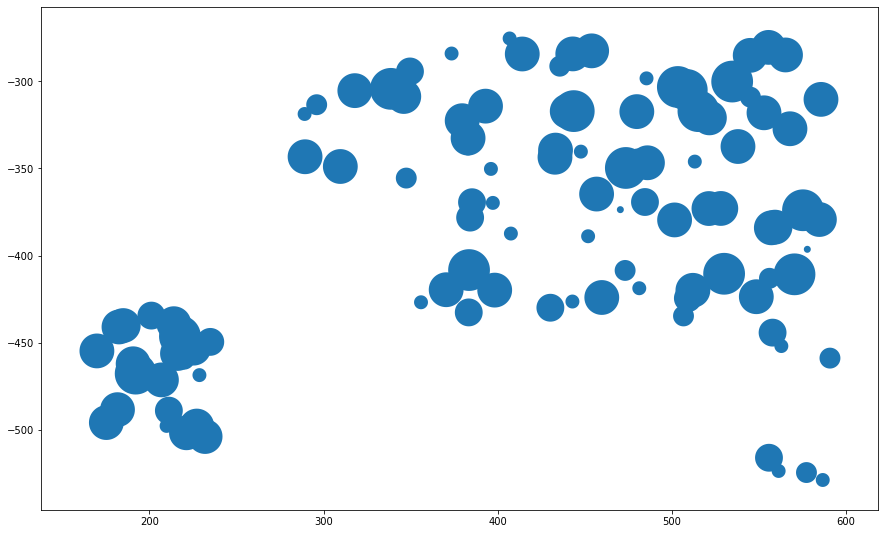

In [78]:
gpd.GeoSeries([a.shape for a in school.cohorts]).plot()